# Cerebellar volumetry analysis with GLM
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32), PPMI/ADNI NC (116/308) QC to be applied.

## Tasks: GLM for 
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, intracranial volume (eTIV, infratentorium, cerebellar volume), site.

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

211011-07:37:12,347 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels
curr_df = data_df.loc[:,analysis_list]
curr_df.loc[:,'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:,'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
curr_df.loc[:,'cerebellumVol']=curr_df['Cerebellum_Cortex']+curr_df['Cerebellum_White_Matter']
# calculate the Infra tentorial volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol']
curr_df.loc[:,'male']=[int(x=='M') for x in curr_df['sex']]


In [3]:
### statistical analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df

# get the MNI dataset for ET/NC analysis
df = curr_df[(curr_df['group']=='ET')|(curr_df['group']=='NC')].copy()

# get all 3 datasets for ET/NC analysis
df_all=curr_df.copy()
df_all.loc[:,'is_mni'] =[1 if int(x=='ET' or x=='NC') else 0 for x in df_all['group']]
df_all.loc[:,'is_ppmi']=[int(x=='PPMI') for x in df_all['group']]
df_all.loc[:,'is_adni']=[int(x=='ADNI') for x in df_all['group']]
df_all.loc[:,'group']  =[x if x=='ET' else 'NC' for x in df_all['group']]

# get indicator variable
alpha_=5; n_permu_=5000;

## covariates and target labels
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
tar_list = cerebellum_list+lobular_list;

df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])
sts_tests_list = ['Cohen_d', 'rank_sum']; 
group_mni_list = ['ET','NC'];

Text(0.5, 1.0, 'Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol')

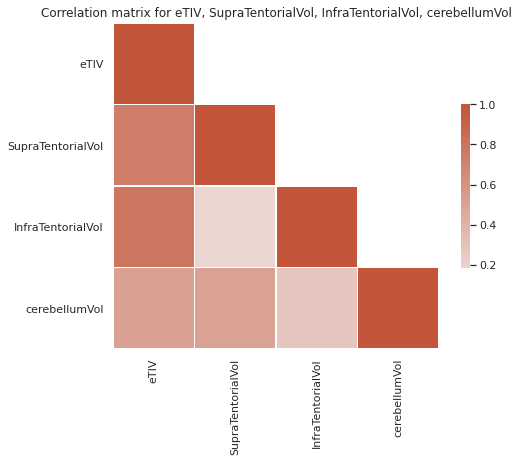

In [4]:
# report correlation between the intracranial volumes for controling
import matplotlib.pyplot as plt
vol_list = ['eTIV', 'SupraTentorialVol', 'InfraTentorialVol', 'cerebellumVol'];
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr_df=df[vol_list]
corr_=corr_df.corr()
mask = np.triu(np.ones_like(corr_, dtype=bool), k=1)
f, ax = plt.subplots(figsize=(8, 6))
ax=sns.heatmap(corr_, mask=mask, cmap=cmap, vmax=1, center=0, xticklabels=vol_list, yticklabels=vol_list,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation matrix for eTIV, SupraTentorialVol, InfraTentorialVol, cerebellumVol')

# GLM analysis for MNI dataset ET/NC (38/32)

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [8]:
# GLM Model 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

alpha_=0.05
# basic GLM
tmp_df = df.copy() 

# Using eTIV as covariate
covariate_model_str = '~age+male+eTIV+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_str);
rep_model(covariate_dict,{'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_})
rep_model(covariate_dict,{'name':'all'});

# Using InfraTentorialVol as covariate
#covariate_model_str_infra = '~age+male+InfraTentorialVol+C(group, Treatment(reference="NC"))';
#covariate_dict_infra = glm_test(tmp_df, tar_list, covariate_model_str_infra);
#rep_model(covariate_dict_infra)

# using cerebellumVol as covariate
#covariate_model_str_cere = '~age+male+cerebellumVol+C(group, Treatment(reference="NC"))';
#covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_str_cere);
#rep_model(covariate_dict_cere)

Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

Display all results:



Left_Cerebellum_Cortex~age+male+eTIV+C(group, Treatment(reference="NC")) 

                                 Results: Generalized linear model
Model:                        GLM                            AIC:                    1336.5913     
Link Function:                identity                       BIC:                    696739875.0147
Dependent Variable:           Left_Cerebellum_Cortex         Log-Likelihood:         -663.30       
Date:                         2021-10-11 07:37               LL-Null:                -689.34       
No. Observations:             70                             Deviance:               6.9674e+08    
Df Model:                     4                              Pearson chi2:           6.97e+08      
Df Residuals:                 65                             Scale:                  1.0719e+07    
Method:                       IRLS        

# GLM analysis for augmented dataset ET/NC (38/32+116+308)

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

# GLM analysis for MNI dataset

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [ ]:
# GLM Model 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

# basic GLM
tmp_all_df = df_all.copy() 

covariate_model_all_str = '~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))';
covariate_all_dict = glm_test(tmp_all_df, tar_list, covariate_model_all_str);
rep_model(covariate_all_dict)

In [ ]:
# distribution testing code
import seaborn as sns
sns.pairplot(tmp_df[['group']+tar_list[0:3]], hue="group")
sns.pairplot(df[['group']+tar_list[0:3]], hue="group")

In [ ]:
# experimental code

# age transformation
#tmp_df.loc[:,'age'] = (tmp_df['age']-tmp_df.age.mean());

# y transformation
#for x in tar_list:
    # proportion
#    tmp_df.loc[:,x] = np.log( (tmp_df.loc[:,x]/tmp_df.loc[:,'eTIV']) /(1-tmp_df.loc[:,x]/tmp_df.loc[:,'eTIV']) );
    
    # logit: np.log( (tmp_df.loc[:,x]/tmp_df.loc[:,'eTIV']) /(1-tmp_df.loc[:,x]/tmp_df.loc[:,'eTIV']) );
    # box-cox: lambda_=5  tmp_df.loc[:,x] = (np.power(tmp_df.loc[:,x]/10000, lambda_)-1) / lambda_
    # log: np.log((tmp_df[x]-tmp_df[x].mean())/1000)
    
# rescale intracranial volume 
#tmp_df.loc[:,'eTIV'] = (tmp_df['eTIV']-tmp_df.eTIV.mean())/1000;
#tmp_df.loc[:,'cerebellumVol'] = (tmp_df['cerebellumVol']-tmp_df.eTIV.mean())/1000;
#tmp_df.loc[:,'InfraTentorialVol'] = (tmp_df['InfraTentorialVol']-tmp_df.eTIV.mean())/1000;
# using eTIV as covariate +eTIV +male